# Problem Statement and Hypothesis Generation

>*Given the features that contain the customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month, the aim is to build a predictive model to determine the purchase amount of customer against various products which will help them to create personalized offer for customers against different products..* 

$H_{0}$ : None of the variables (below)contributes significantly to the prediction of the model.

$H_{1}$ : At least one of the variables (below) contribute significantly impact on the dependent variable.

| Variables | Definition   |
|------|------|
| User_ID | User ID |
| Product_ID | Product ID |
| Gender |	Sex of User |
| Age |	Age in bins |
| Occupation |	Occupation (Masked)|
| City_Category |	Category of the City (A,B,C)|
| Stay_In_Current_City_Years |	Number of years stay in current city |
| Marital_Status |	Marital Status |
| Product_Category_1 |	Product Category (Masked) |
| Product_Category_2 |	Product may belongs to other category also (Masked) |
| Product_Category_3 |	Product may belongs to other category also (Masked) |
| Purchase |	Purchase Amount (Target Variable)|

# Data Exploration

In [153]:
import os
import glob
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import statsmodels.api as sm
import numpy as np
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_rows',9)
pd.set_option('display.max_columns', 9)
pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
plt.style.use('ggplot')

## Importing the Train Data-Set

In [18]:
df_train = pd.read_csv('train.csv')
df_train_2 = pd.read_csv('train_mod_tableau.csv')

#Droping the columms that have more than 80% missing values
df_train = df_train.loc[:, pd.notnull(df_train).sum()>len(df_train)*.8]

In [20]:
df_train_2 = df_train_2.fillna(0)
df_train_2

,User ID,Age,City Category,Stay In Current City Years,...,18,19,20,Total Purchase
0,1000001,0-17,A,2,...,0.0,0.0,1.0,334093
1,1000002,55+,C,4+,...,0.0,0.0,1.0,810472
2,1000003,26-35,A,3,...,1.0,0.0,0.0,341635
3,1000004,46-50,B,2,...,0.0,0.0,1.0,206468
...,...,...,...,...,...,...,...,...,...
5887,1006037,46-50,C,4+,...,1.0,0.0,0.0,1119538
5888,1006038,55+,C,2,...,0.0,0.0,1.0,90034
5889,1006039,46-50,B,4+,...,0.0,0.0,1.0,590319
5890,1006040,26-35,B,2,...,0.0,0.0,0.0,1653299


In [21]:
df_train['Gender'] = df_train.Gender.map({'F': 0 , 'M': 1})
df_train_2['Gender'] = df_train_2.Gender.map({'F': 0 , 'M': 1})

### Analysing the Variable Age

As we can see, the data set consists of people aged from 0 to 55+ with frequency of people declining with age. Now, if we think of the problem we are trying to solve, the population between ages of 26 to 35 appear to spend more than the other groups. Given us an incentive to think that targeting young adults might be good marketing strategy.

Also, it highlights that for ages inside these categories "0-17", "46-50", "51-55" and "55+" its total purchase is lower than \$500,000,000.00 and that the probabily of belonging to any of these categories compare to the other categories surpass the quote. So, to reduce the complexity of the model I will classify the categories that belong to Age in 0 for the total purchase below \$500,000,000.00 and 1 for the contrary.

In [118]:
pd.crosstab(index = df_train["Age"], columns="Frequency")/df_train["Age"].count()

col_0,Frequency
Age,
0-17,0.027455
18-25,0.181178
26-35,0.399200
36-45,0.199999
46-50,0.083082
51-55,0.069993
55+,0.039093


In [119]:
df_train[['Age','Purchase']].groupby(['Age']).median()

,Purchase
Age,
0-17,7986.0
18-25,8027.0
26-35,8030.0
36-45,8061.0
46-50,8036.0
51-55,8130.0
55+,8105.5


In [22]:
df_train.Age.loc[lambda s: s == '18-25'] = '18-50'
df_train.Age.loc[lambda s: s == '26-35'] = '18-50'
df_train.Age.loc[lambda s: s == '36-45'] = '18-50'
df_train.Age.loc[lambda s: s == '46-50'] = '18-50'
df_train.Age.loc[lambda s: s == '51-55'] = '51+'
df_train.Age.loc[lambda s: s == '55+'] = '51+'

In [23]:
dummies = pd.get_dummies(df_train['Age'])
dummies = dummies.drop(['0-17'],axis = 1)
df_train = pd.concat([df_train, dummies], axis=1)

In [24]:
dummies = pd.get_dummies(df_train_2['Age'])
dummies = dummies.drop(['0-17'],axis = 1)
df_train_2 = pd.concat([df_train_2, dummies], axis=1)

### Analysing the Variable Occupation with the Age in function of the total Purchase

The bar chart below deals with the Total Purchase of every group of Age in the occupation in which they are in. It helps identify if any trend exist or if there is a possibilty of an outlier. 

Looking at the graph, the number total of purchase for people with the occupation "4" and that belong to the range of Age of 18-25 increases dramatically compared to the other purchase of the people that share the same traits. Can it be an outlier? Further analysis must be needed to get to a more concrete conclusion about the fate of the data in question.



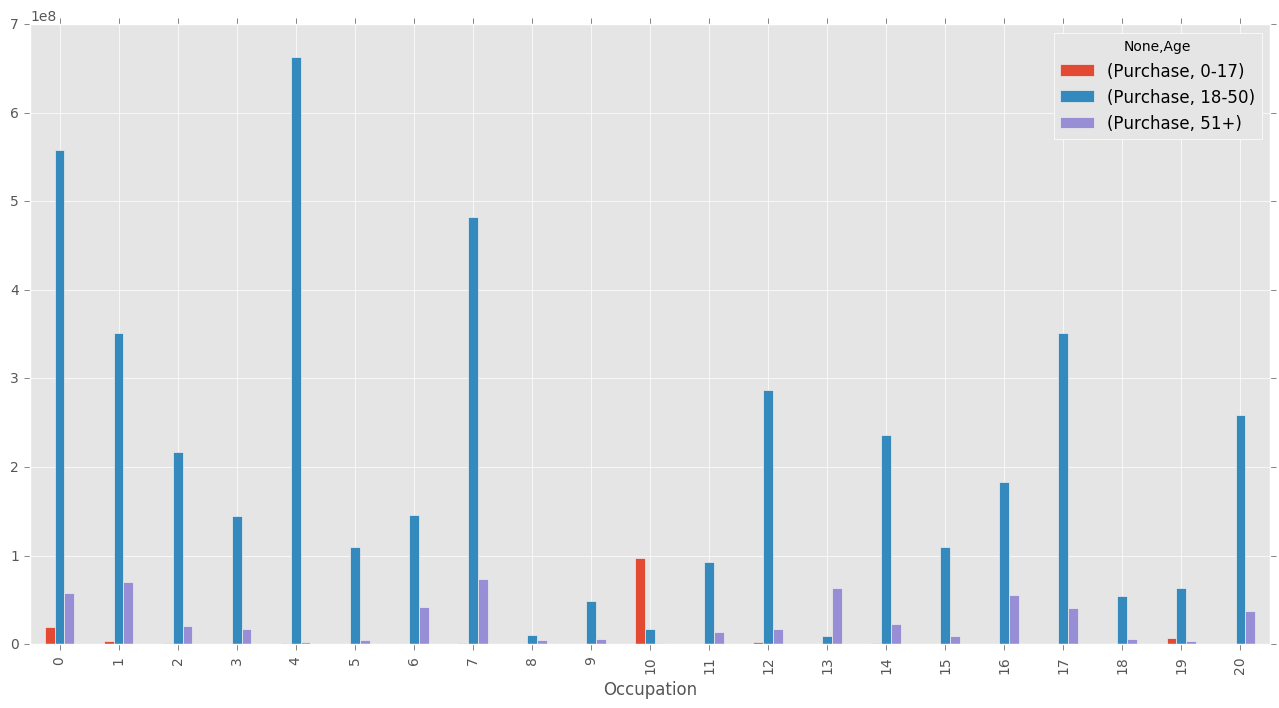

In [123]:
df_bar = df_train[['Occupation','Age','Purchase']].groupby(['Occupation','Age']).sum()
df_bar = df_bar.unstack()
df_bar.plot(kind='bar',figsize = (16, 8))

In [25]:
dummies = pd.get_dummies(df_train_2['Occupation'],prefix = 'Occupation')
dummies = dummies.drop(['Occupation_8'],axis = 1)
df_train_2 = pd.concat([df_train_2, dummies], axis=1)

### Creating dummies variables for the City Category

In [27]:
dummies = pd.get_dummies(df_train['City_Category'])
dummies = dummies.drop(['C'],axis = 1)
df_train = pd.concat([df_train, dummies], axis=1)

dummies = pd.get_dummies(df_train_2['City Category'])
dummies = dummies.drop(['C'],axis = 1)
df_train_2 = pd.concat([df_train_2, dummies], axis=1)

### Creating dummies variables for the Current Stayed in Years

In [125]:
df_train['Stay_In_Current_City_Years'] = df_train.Stay_In_Current_City_Years.map({'0': 0 , '1': 1, '2': 2, '3': 3,'4+': 4})

In [126]:
df_train[['Stay_In_Current_City_Years','Purchase']].groupby(['Stay_In_Current_City_Years']).mean()

,Purchase
Stay_In_Current_City_Years,
0,9180.075123
1,9250.145923
2,9320.429810
3,9286.904119
4,9275.598872


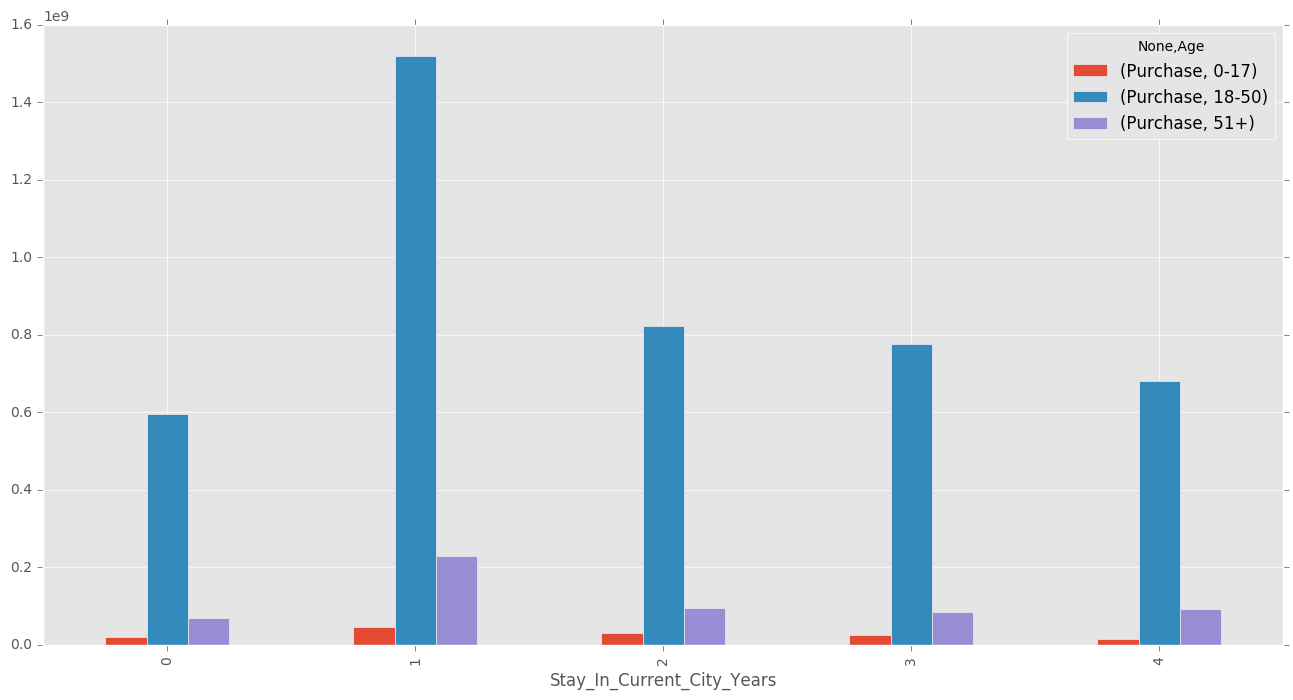

In [127]:
df_bar = df_train[['Stay_In_Current_City_Years','Age','Purchase']].groupby(['Stay_In_Current_City_Years','Age']).sum()
df_bar = df_bar.unstack()
df_bar.plot(kind='bar',figsize = (16, 8))

In [348]:
dummies = pd.get_dummies(df_train_2['Stay_In_Current_City_Years'],prefix = 'Years_Stayed')
dummies = dummies.drop(['Years_Stayed_0'],axis = 1)
df_train_2 = pd.concat([df_train_2, dummies], axis=1)

### Analysing the Product Category

In [128]:
df_train[['Product_Category_1','Purchase']].groupby(['Product_Category_1']).median()

,Purchase
Product_Category_1,
1,15245.0
2,12728.5
3,10742.0
4,2175.0
...,...
17,10435.5
18,3071.0
19,37.0
20,368.0


In [129]:
for x in df_train.Product_Category_1.unique():
    if df_train[df_train.Product_Category_1 == x]['Purchase'].median() < 100:
        df_train.Product_Category_1.loc[lambda s: s == x] = "Purchase_Lower_than_100"
    elif df_train[df_train.Product_Category_1 == x]['Purchase'].median() < 1000:
        df_train.Product_Category_1.loc[lambda s: s == x] = "Purchase_Lower_than_1k"
    elif df_train[df_train.Product_Category_1 == x]['Purchase'].median() < 5000:
        df_train.Product_Category_1.loc[lambda s: s == x] = "Purchase_Lower_than_5k"
    elif df_train[df_train.Product_Category_1 == x]['Purchase'].median() < 10000:
        df_train.Product_Category_1.loc[lambda s: s == x] = "Purchase_Lower_than_10k"
    elif df_train[df_train.Product_Category_1 == x]['Purchase'].median() < 15000:
        df_train.Product_Category_1.loc[lambda s: s == x] = "Purchase_Lower_than_15k"
    else:
        df_train.Product_Category_1.loc[lambda s: s == x] = "Purchase_above_15k"

In [136]:
dummies = pd.get_dummies(df_train['Product_Category_1'])
dummies = dummies.drop(['Purchase_Lower_than_100'],axis = 1)
df_train = pd.concat([df_train, dummies], axis=1)

In [28]:
df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5891 entries, 0 to 5890
Data columns (total 56 columns):
User ID                       5891 non-null int64
Age                           5891 non-null object
City Category                 5891 non-null object
Stay In Current City Years    5891 non-null object
Gender                        5891 non-null int64
Marital Status                5891 non-null int64
Occupation                    5891 non-null int64
1                             5891 non-null float64
2                             5891 non-null float64
3                             5891 non-null float64
4                             5891 non-null float64
5                             5891 non-null float64
6                             5891 non-null float64
7                             5891 non-null float64
8                             5891 non-null float64
9                             5891 non-null float64
10                            5891 non-null float64
11                  

# Defining the response and predictive values

In [191]:
X = df_train_2[['1','5','8']]
y = df_train_2['Total Purchase']

## Fitting Random Forest Regression to the dataset

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_test = np.asarray(y_test)

In [202]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [203]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. 1 (0.649656)
2. 8 (0.207013)
3. 5 (0.143330)


In [204]:
regressor.score(X_test, y_test)

0.94229114498105093

In [205]:
y_hat = regressor.predict(X_test)
MSE = y_test-y_hat
MSE = MSE*MSE
MSE = sum(MSE)
MSE = MSE/len(y_test)
RMSE = MSE**(1./2)
RMSE

243618.40613431612

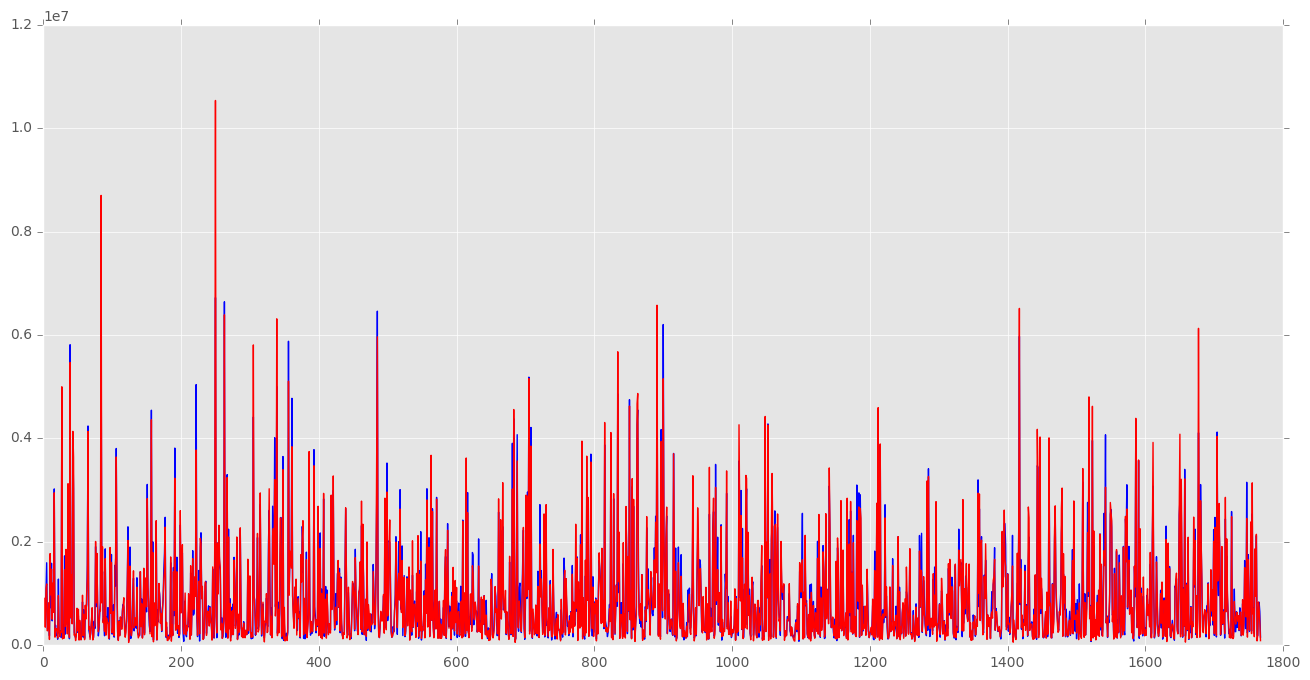

In [221]:
plt.figure(figsize=(16,8))
plt.plot(y_hat,'b') 
plt.plot(y_test,'r') 
plt.show()
